In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from mermaid import Mermaid
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from src.prompts.planner_model import StepType

from src.graph.types import State
from src.graph.nodes import (
    coordinator_node,
    planner_node,
    reporter_node,
    research_team_node,
    researcher_node,
    coder_node,
    human_feedback_node,
    background_investigation_node,
)

In [2]:
def continue_to_running_research_team(state: State):
    current_plan = state.get("current_plan")
    if not current_plan or not current_plan.steps:
        return "planner"
    if all(step.execution_res for step in current_plan.steps):
        return "planner"
    for step in current_plan.steps:
        if not step.execution_res:
            break
    if step.step_type and step.step_type == StepType.RESEARCH:
        return "researcher"
    if step.step_type and step.step_type == StepType.PROCESSING:
        return "coder"
    return "planner"

In [3]:
def _build_base_graph():
    """Build and return the base state graph with all nodes and edges."""
    builder = StateGraph(State)
    builder.add_edge(START, "coordinator")
    builder.add_node("coordinator", coordinator_node)
    builder.add_node("background_investigator", background_investigation_node)
    builder.add_node("planner", planner_node)
    builder.add_node("reporter", reporter_node)
    builder.add_node("research_team", research_team_node)
    builder.add_node("researcher", researcher_node)
    builder.add_node("coder", coder_node)
    builder.add_node("human_feedback", human_feedback_node)
    builder.add_edge("background_investigator", "planner")
    builder.add_conditional_edges(
        "research_team",
        continue_to_running_research_team,
        ["planner", "researcher", "coder"],
    )
    builder.add_edge("reporter", END)
    return builder

In [4]:
def build_graph():
    """Build and return the agent workflow graph without memory."""
    # build state graph
    builder = _build_base_graph()
    return builder.compile()

In [5]:
graph = build_graph()

In [6]:
Mermaid(graph.get_graph(xray=True).draw_mermaid())

In [7]:
question = """What is the outlook for the cloud computing industry both in the west and emerging markets or regions?
What are some of the drivers of its growth and possible challenges or constraints?  What does the competitive landscape look like for leading
providers of cloud services?"""

In [8]:
initial_state = {
        # Runtime Variables
        "messages": [{"role": "user", "content": question}],
        "auto_accepted_plan": True,
        "enable_background_investigation": True,
    }

config = {
        "configurable": {
            "thread_id": "default",
            "max_plan_iterations": 1,
            "max_step_num": 3,
            "mcp_settings": {
                "servers": {
                    "mcp-github-trending": {
                        "transport": "stdio",
                        "command": "uvx",
                        "args": ["mcp-github-trending"],
                        "enabled_tools": ["get_github_trending_repositories"],
                        "add_to_agents": ["researcher"],
                    }
                }
            },
        },
        "recursion_limit": 100,
    }

================================ Human Message =================================

What is the outlook for the cloud computing industry both in the west and emerging markets or regions?
What are some of the drivers of its growth and possible challenges or constraints?  What does the competitive landscape look like for leading
providers of cloud services?
sync [
  {
    "type": "page",
    "title": "Cloud Computing Market Size, Trends, Growth Drivers - 2035",
    "url": "https://www.marketresearchfuture.com/reports/cloud-computing-market-1013",
    "content": "**Cloud Computing Market Overview**\n-----------------------------------\n\nAs per MRFR analysis, the Cloud Computing Market Size was estimated at 293.4 (USD Billion) in 2023.The Cloud Computing Market Industry is expected to grow from 318.98(USD Billion) in 2024 to 800 (USD Billion) by 2035. The Cloud Computing Market CAGR (growth rate) is expected to be around 8.72% during the forecast period (2025 - 2035). [...] *   \n\nSmall an
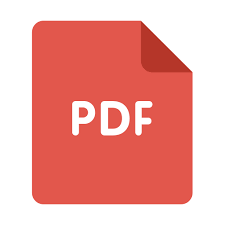

Traceback (most recent call last):
  File "/Users/paulbruffett/Documents/code/agents/deer-flow/.venv/lib/python3.12/site-packages/mcp/client/stdio/__init__.py", line 179, in stdio_client
    process.terminate()
  File "/Users/paulbruffett/.cache/uv/archive-v0/ht4gMzmSVYsIOz6H_JFIB/lib/python3.12/site-packages/anyio/_backends/_asyncio.py", line 1077, in terminate
    self._process.terminate()
  File "/Users/paulbruffett/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/Users/paulbruffett/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/Users/paulbruffett/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError

During handling of the above exception, ano

In [9]:
last_message_cnt = 0
async for s in graph.astream(
    input=initial_state, config=config, stream_mode="values"
):
    try:
        if isinstance(s, dict) and "messages" in s:
            if len(s["messages"]) <= last_message_cnt:
                continue
            last_message_cnt = len(s["messages"])
            message = s["messages"][-1]
            if isinstance(message, tuple):
                print(message)
            else:
                message.pretty_print()
        else:
            # For any other output format
            print(f"Output: {s}")
    except Exception as e:
        logger.error(f"Error processing stream output: {e}")
        print(f"Error processing output: {str(e)}")

logger.info("Async workflow completed successfully")